In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from MPCVelControl_D3_1 import MPCVelControl

from MPCControl_xvel_D3_1 import MPCControl_xvel
from MPCControl_xvel_D3_1 import MPCControl_xvel_tuned_default
from MPCControl_xvel_D3_1 import MPCControl_xvel_tuned_final

from MPCControl_yvel_D3_1 import MPCControl_yvel
from MPCControl_yvel_D3_1 import MPCControl_yvel_tuned_default
from MPCControl_yvel_D3_1 import MPCControl_yvel_tuned_final

from MPCControl_zvel_D3_1 import MPCControl_zvel
from MPCControl_zvel_D3_1 import MPCControl_zvel_tuned_default
from MPCControl_zvel_D3_1 import MPCControl_zvel_tuned_final

from MPCControl_roll_D3_1 import MPCControl_roll
from MPCControl_roll_D3_1 import MPCControl_roll_tuned_default
from MPCControl_roll_D3_1 import MPCControl_roll_tuned_final

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
import matplotlib.pyplot as plt
from plot_style import set_mpc_style
set_mpc_style()

Ts = 0.05
sim_time = 7.0
H = 5.0
N = int(H / Ts)

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

In [4]:
# total system open-loop trajectory for non-stationnary x0: 5 m/s + no roll angle

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = 0; v_x0 = 5; v_y0 = 5; v_z0 = 5 # 5 m/s + no roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !
t0 = 0 # initial timestamp begins at 0 seconds


mpc = MPCVelControl().new_controller(rocket, Ts, H)
u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_ol[:-1], x_ol[:, :-1], u_ol)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 i

/Users/mt/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

{'fig': <Figure size 330x250 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x17f765040>,
 'scene_objects': {'rocket_actor': Actor (0x17f7f2560)
    Center:                     (0.3200699999998223, -0.001508500000315327, 0.5884844999997935)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    -1.212E+00,

In [5]:
# total system open-loop trajectory for stationnary x_0: stationnary + 30° roll angle
omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = np.deg2rad(30); v_x0 = 0; v_y0 = 0; v_z0 = 0 # stationnary + 30° roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0)

vis.animate(t_ol[:-1], x_ol[:, :-1], u_ol)


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

{'fig': <Figure size 330x250 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x1802f0e90>,
 'scene_objects': {'rocket_actor': Actor (0x18018ab60)
    Center:                     (0.060356440456485805, -0.21257898309336443, 0.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -1.002E+00, 1.122E+00
    Y Bounds                    -1.264E+00

In [6]:
# total system open-loop trajectory for stationnary x_0: non-stationnary + 30° roll angle
xs, us = rocket.trim()

x0_full = xs.copy()
x0_full[5] = np.deg2rad(30)
x0_full[6] = 5
x0_full[7] = 5
x0_full[8] = 5

u0_ol, x_ol, u_ol, t_ol = mpc.get_u(t0, x0_full)

vis.animate(t_ol[:-1], x_ol[:, :-1], u_ol)

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=99, step=2), IntSlider(value=0,…

{'fig': <Figure size 330x250 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x180615610>,
 'scene_objects': {'rocket_actor': Actor (0x1805c51e0)
    Center:                     (0.0603564404561705, -0.21257898309367973, 0.5884844999997212)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -1.002E+00, 1.122E+00
    Y Bounds                    -1.264E+00, 

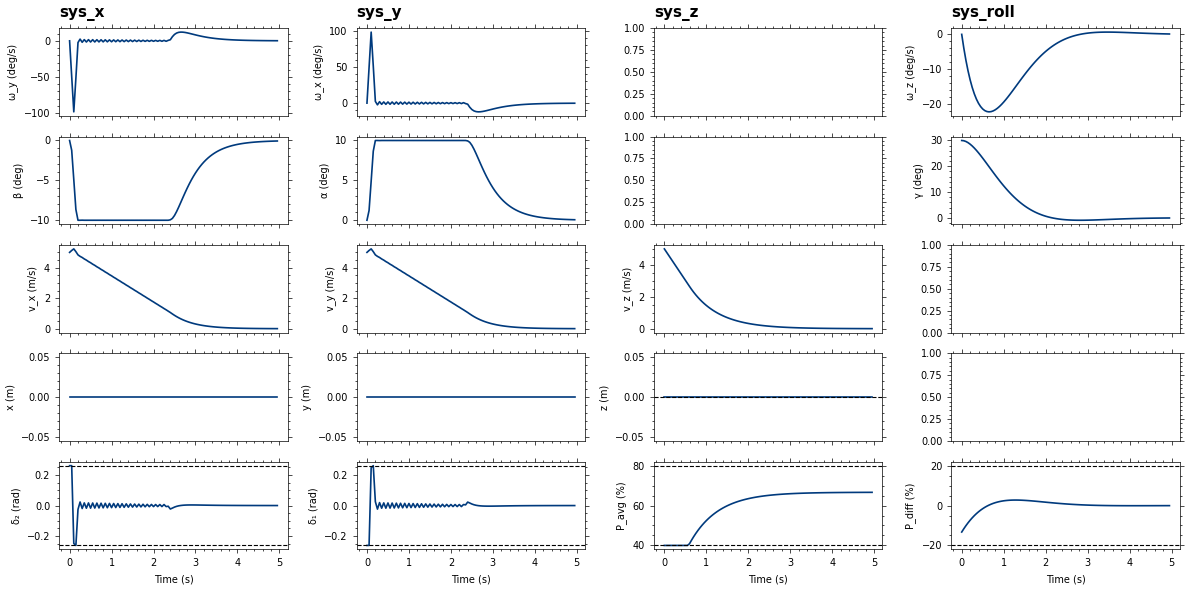

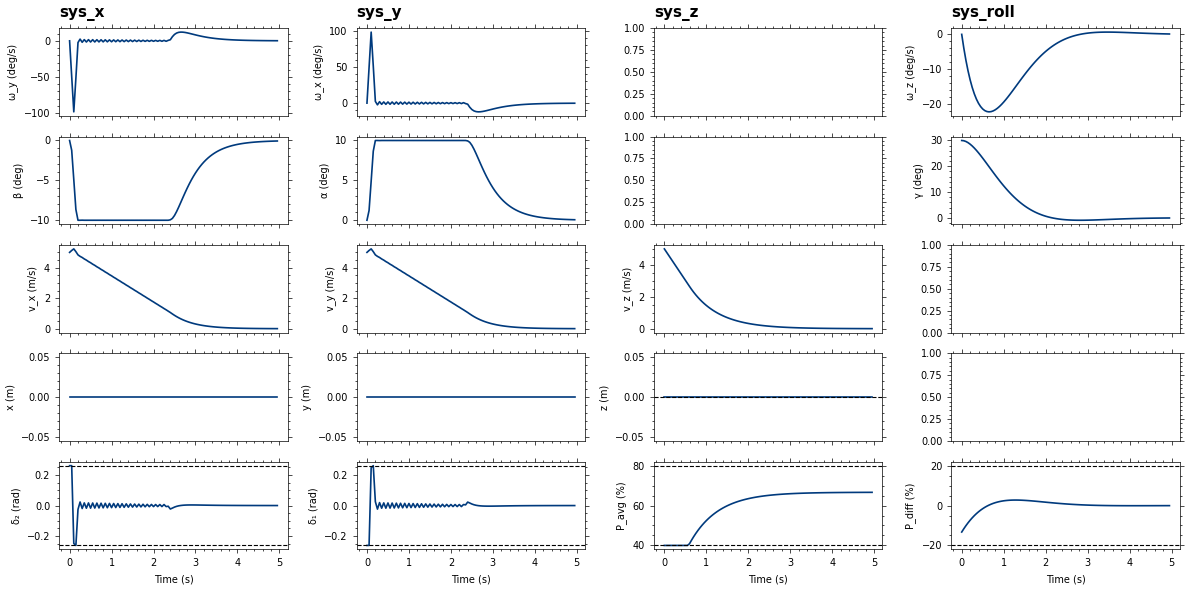

In [7]:
from src.vel_rocket_vis import plot_static_states_inputs
import matplotlib.pyplot as plt

T = t_ol[:-1]
X = x_ol[:, :-1]
U = u_ol

plot_static_states_inputs(T, X, U)

plt.savefig("openloop_states_inputs.pdf", bbox_inches="tight")
plt.show()

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Maximum invariant set found after 14 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet co

/Users/mt/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


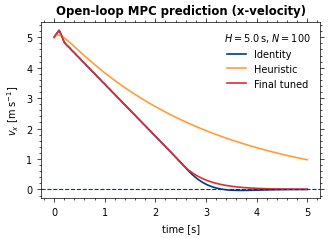

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Maximum invariant set found after 14 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet co

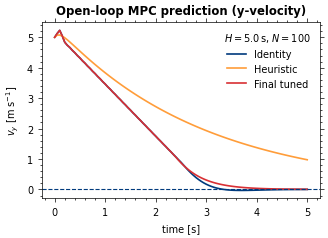

Maximum invariant set found after 1 iterations !

Maximum invariant set found after 1 iterations !

Maximum invariant set found after 1 iterations !



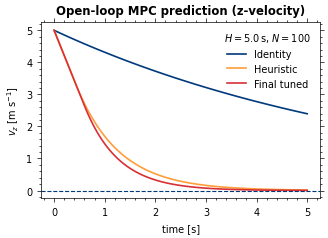

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at iteration 18
Not yet convgerged at iteration 19
Not yet convgerged at iteration 20
Not yet convgerged at iteration 21
Not yet convgerged at iteration 22
Not yet convgerged at iteration 23
Not yet convgerged at iteration 24
Not yet convgerged at iteration 25
Not yet convgerged at iteration 26
Not yet convgerged at iteration 27
Not yet convgerged at iteration 28
Not yet convgerged at iterati

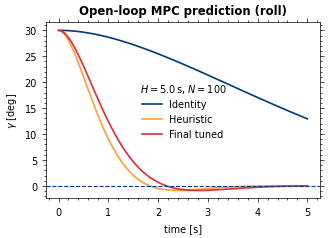

In [8]:
# Open-loop plot which superimpose three differently tuned Q and R trajectory plots as three indepent plots

# 5 m/s + 30° roll angle

xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)

# Open-loop MPC prediction for x-velocity controller
mpc_x_I   = MPCControl_xvel(A, B, xs, us, Ts, H)
mpc_x_td  = MPCControl_xvel_tuned_default(A, B, xs, us, Ts, H)
mpc_x_tf  = MPCControl_xvel_tuned_final(A, B, xs, us, Ts, H)

x0_x = xs.copy()
x0_x[6] = 5.0  # v_x = 5 m/s

_, xI,  _ = mpc_x_I.get_u(x0_x[mpc_x_I.x_ids])
_, xTD, _ = mpc_x_td.get_u(x0_x[mpc_x_td.x_ids])
_, xTF, _ = mpc_x_tf.get_u(x0_x[mpc_x_tf.x_ids])

t_ol = np.arange(xI.shape[1]) * Ts

vx_local_idx = 2  # for x_ids=[1,4,6] -> [w_y, beta, v_x]

plt.figure(figsize=(3.4, 2.5))
plt.plot(t_ol, xI[vx_local_idx, :],  label="Identity")
plt.plot(t_ol, xTD[vx_local_idx, :], label=r"Heuristic")
plt.plot(t_ol, xTF[vx_local_idx, :], label="Final tuned")
plt.axhline(0.0, linestyle="--", linewidth=0.8)
plt.xlabel(r"time [s]")
plt.ylabel(r"$v_x$ [m s$^{-1}$]")
plt.title("Open-loop MPC prediction (x-velocity)")
plt.legend(
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    frameon=False,
    fontsize=7,
    title_fontsize=7
)
plt.tight_layout()
plt.show()

# Open-loop MPC prediction for y-velocity controller
mpc_y_I  = MPCControl_yvel(A, B, xs, us, Ts, H)
mpc_y_td = MPCControl_yvel_tuned_default(A, B, xs, us, Ts, H)
mpc_y_tf = MPCControl_yvel_tuned_final(A, B, xs, us, Ts, H)

x0_y = xs.copy()
x0_y[7] = 5.0

_, xI,  _ = mpc_y_I.get_u(x0_y[mpc_y_I.x_ids])
_, xTD, _ = mpc_y_td.get_u(x0_y[mpc_y_td.x_ids])
_, xTF, _ = mpc_y_tf.get_u(x0_y[mpc_y_tf.x_ids])

t_ol = np.arange(xI.shape[1]) * Ts
vy_local_idx = list(mpc_y_I.x_ids).index(7)

plt.figure(figsize=(3.4, 2.5))
plt.plot(t_ol, xI[vy_local_idx, :],  label="Identity")
plt.plot(t_ol, xTD[vy_local_idx, :], label=r"Heuristic")
plt.plot(t_ol, xTF[vy_local_idx, :], label="Final tuned")
plt.axhline(0.0, linestyle="--", linewidth=0.8)
plt.xlabel(r"time [s]")
plt.ylabel(r"$v_y$ [m s$^{-1}$]")
plt.title("Open-loop MPC prediction (y-velocity)")
plt.legend(
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    frameon=False,
    fontsize=7,
    title_fontsize=7
)
plt.tight_layout()
plt.show()

# Open-loop MPC prediction for z-velocity controller
mpc_z_I  = MPCControl_zvel(A, B, xs, us, Ts, H)
mpc_z_td = MPCControl_zvel_tuned_default(A, B, xs, us, Ts, H)
mpc_z_tf = MPCControl_zvel_tuned_final(A, B, xs, us, Ts, H)

x0_z = xs.copy()
x0_z[8] = 5.0

_, xI,  _ = mpc_z_I.get_u(x0_z[mpc_z_I.x_ids])
_, xTD, _ = mpc_z_td.get_u(x0_z[mpc_z_td.x_ids])
_, xTF, _ = mpc_z_tf.get_u(x0_z[mpc_z_tf.x_ids])

t_ol = np.arange(xI.shape[1]) * Ts
vz_local_idx = list(mpc_z_I.x_ids).index(8)

plt.figure(figsize=(3.4, 2.5))
plt.plot(t_ol, xI[vz_local_idx, :],  label="Identity")
plt.plot(t_ol, xTD[vz_local_idx, :], label=r"Heuristic")
plt.plot(t_ol, xTF[vz_local_idx, :], label="Final tuned")
plt.axhline(0.0, linestyle="--", linewidth=0.8)
plt.xlabel(r"time [s]")
plt.ylabel(r"$v_z$ [m s$^{-1}$]")
plt.title("Open-loop MPC prediction (z-velocity)")
plt.legend(
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    frameon=False,
    fontsize=7,
    title_fontsize=7
)
plt.tight_layout()
plt.show()


# Open-loop MPC prediction for roll-rate controller
mpc_r_I  = MPCControl_roll(A, B, xs, us, Ts, H)
mpc_r_td = MPCControl_roll_tuned_default(A, B, xs, us, Ts, H)
mpc_r_tf = MPCControl_roll_tuned_final(A, B, xs, us, Ts, H)

x0_gamma = xs.copy()
x0_gamma[5] = np.deg2rad(30)   # γ = 30°

_, xI,  _ = mpc_r_I.get_u(x0_gamma[mpc_r_I.x_ids])
_, xTD, _ = mpc_r_td.get_u(x0_gamma[mpc_r_td.x_ids])
_, xTF, _ = mpc_r_tf.get_u(x0_gamma[mpc_r_tf.x_ids])

t_ol = np.arange(xI.shape[1]) * Ts
gamma_idx = 1  # local index in [ω_z, γ]

plt.figure(figsize=(3.4, 2.5))
plt.plot(t_ol, np.rad2deg(xI[gamma_idx]),  label="Identity")
plt.plot(t_ol, np.rad2deg(xTD[gamma_idx]), label=r"Heuristic")
plt.plot(t_ol, np.rad2deg(xTF[gamma_idx]), label="Final tuned")
plt.axhline(0.0, linestyle="--", linewidth=0.8)
plt.xlabel(r"time [s]")
plt.ylabel(r"$\gamma$ [deg]")
plt.title("Open-loop MPC prediction (roll)")
plt.legend(
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    frameon=False,
    fontsize=7,
    title_fontsize=7
)
plt.tight_layout()
plt.show()


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Maximum invariant set found after 14 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet co

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at iteration 18
Not yet convgerged at iteration 19
Not yet convgerged at iteration 20
Not yet convgerged at iteration 21
Not yet convgerged at iteration 22
Not yet convgerged at iteration 23
Not yet convgerged at iteration 24
Not yet convgerged at iteration 25
Not yet convgerged at iteration 26
Not yet convgerged at iteration 27
Not yet convgerged at iteration 28
Not yet convgerged at iterati

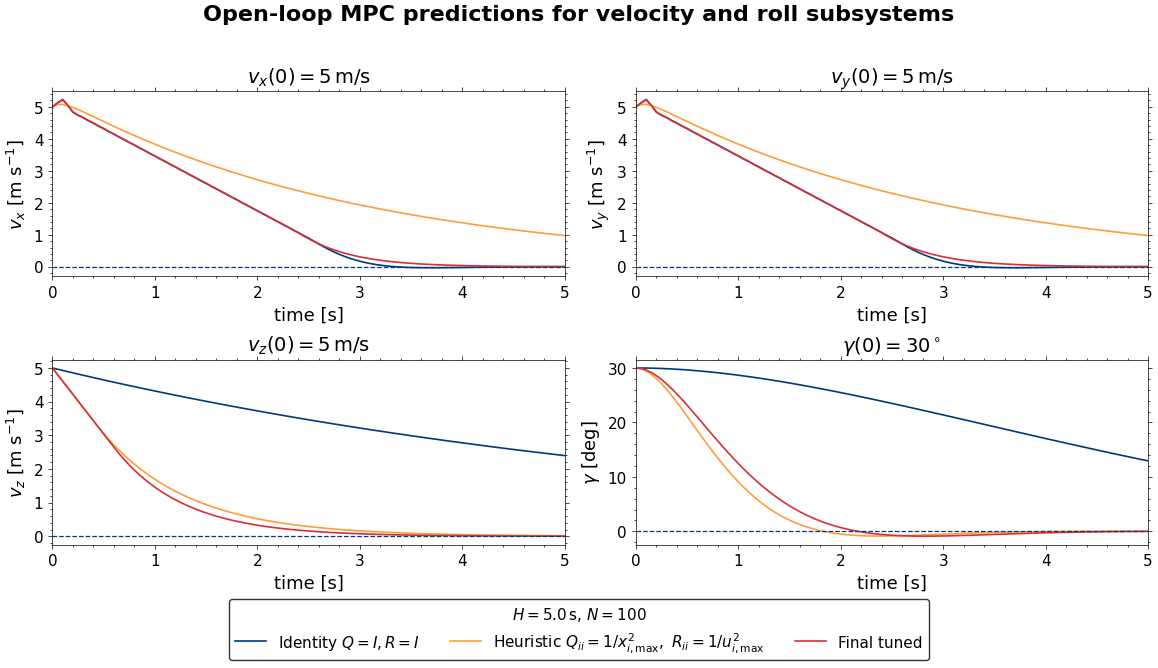

In [9]:
# Open-loop plot which superimpose three differently tuned Q and R trajectory plots as one single plot

# 5 m/s + 30° roll angle

import numpy as np
import matplotlib.pyplot as plt

# ---------- helper ----------
def run_open_loop(mpc_cls, A, B, xs, us, Ts, H, x0_full, state_full_idx,
                  y_transform=lambda y: y):
    mpc = mpc_cls(A, B, xs, us, Ts, H)
    x0_sub = x0_full[mpc.x_ids]
    _, x_ol, _ = mpc.get_u(x0_sub)

    t = np.arange(x_ol.shape[1]) * Ts
    local_idx = list(mpc.x_ids).index(state_full_idx)
    y = y_transform(x_ol[local_idx, :])
    return t, y


# ---------- initial conditions ----------
x0_x = xs.copy(); x0_x[6] = 5.0
x0_y = xs.copy(); x0_y[7] = 5.0
x0_z = xs.copy(); x0_z[8] = 5.0
x0_r = xs.copy(); x0_r[5] = np.deg2rad(30.0)

# ---------- controller sets ----------
ctrl_sets = {
    "Identity $Q=I,R=I$": (
        MPCControl_xvel, MPCControl_yvel,
        MPCControl_zvel, MPCControl_roll
    ),
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": (
        MPCControl_xvel_tuned_default,
        MPCControl_yvel_tuned_default,
        MPCControl_zvel_tuned_default,
        MPCControl_roll_tuned_default
    ),
    "Final tuned": (
        MPCControl_xvel_tuned_final,
        MPCControl_yvel_tuned_final,
        MPCControl_zvel_tuned_final,
        MPCControl_roll_tuned_final
    ),
}

# ---------- figure ----------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))

fig.suptitle(
    "Open-loop MPC predictions for velocity and roll subsystems",
    fontsize=16,
    fontweight="bold",
    y=0.98
)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11

def format_ax(ax, title, ylabel):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.axhline(0.0, linestyle="--", linewidth=0.9)
    ax.set_xlim(0, H)
    ax.tick_params(labelsize=TICK_FONTSIZE)

# ---------- X velocity ----------
ax = axs[0, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cx, A, B, xs, us, Ts, H, x0_x, 6)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_x(0)=5\,\mathrm{m/s}$", r"$v_x$ [m s$^{-1}$]")

# ---------- Y velocity ----------
ax = axs[0, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cy, A, B, xs, us, Ts, H, x0_y, 7)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_y(0)=5\,\mathrm{m/s}$", r"$v_y$ [m s$^{-1}$]")

# ---------- Z velocity ----------
ax = axs[1, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cz, A, B, xs, us, Ts, H, x0_z, 8)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"$v_z(0)=5\,\mathrm{m/s}$", r"$v_z$ [m s$^{-1}$]")

# ---------- Roll angle ----------
ax = axs[1, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cr, A, B, xs, us, Ts, H, x0_r, 5, np.rad2deg)
    ax.plot(t, y, label=lbl)
ax.set_title(r"$\gamma(0)=30^\circ$", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
ax.set_ylabel(r"$\gamma$ [deg]", fontsize=LABEL_FONTSIZE)
ax.axhline(0.0, linestyle="--", linewidth=0.9)
ax.set_xlim(0, H)
ax.tick_params(labelsize=TICK_FONTSIZE)

# ---------- legend ----------
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=3,
    fontsize=LEGEND_FONTSIZE,
    frameon=True,
    fancybox=True,
    edgecolor="black",
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    title_fontsize=LEGEND_FONTSIZE
)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])

# ---------- save ----------
fig.savefig("openloop_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()


In [10]:
# Closed-loop trajectory for non-stationnary x0

# 5 m/s + no roll angle

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = 0; v_x0 = 5; v_y0 = 5; v_z0 = 5 # 5 m/s + no roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

x0_full = np.zeros(12)
x0_full[:9] = x0

mpc = MPCVelControl().new_controller(rocket, Ts, H)
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_full, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 1

/Users/mt/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating time 2.15: 
Simulating

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

{'fig': <Figure size 330x250 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x17c39e5a0>,
 'scene_objects': {'rocket_actor': Actor (0x17f315300)
    Center:                     (0.32006999999999997, -0.0015085000000000237, 0.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    -1.212E+0

In [11]:
# closed-loop trajectory for stationnary x0

# stationnary + 30° roll angle

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = np.deg2rad(30); v_x0 = 0; v_y0 = 0; v_z0 = 0 # stationnary + 30° roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

x0_full = np.zeros(12)
x0_full[:9] = x0

mpc = MPCVelControl().new_controller(rocket, Ts, H)
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0_full, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3


Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Maximum invariant set found after 18 iterations !

Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating t

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

{'fig': <Figure size 330x250 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x17f218e90>,
 'scene_objects': {'rocket_actor': Actor (0x17c1797e0)
    Center:                     (0.06035644045648636, -0.21257898309336404, 0.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -1.002E+00, 1.122E+00
    Y Bounds                    -1.264E+00,

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9


Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iter

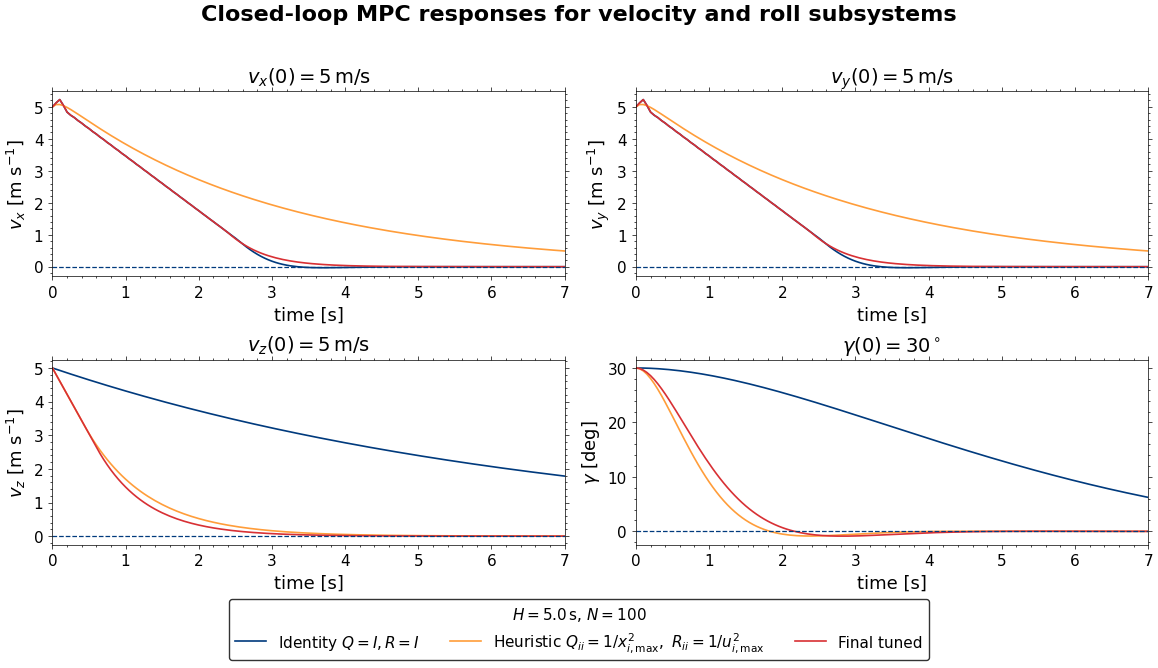

In [12]:
# Closed-loop plot which superimpose three differently tuned Q and R trajectory plots as one single plot

# 5 m/s + 30° roll angle

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Make 3 MPCVelControl variants
# -----------------------------
from LinearMPC_template.MPCVelControl import MPCVelControl

class MPCVelControl_I(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        xs, us = rocket.trim()
        A, B = rocket.linearize(xs, us)
        self.xs, self.us = xs, us

        self.mpc_x    = MPCControl_xvel(A, B, xs, us, Ts, H)
        self.mpc_y    = MPCControl_yvel(A, B, xs, us, Ts, H)
        self.mpc_z    = MPCControl_zvel(A, B, xs, us, Ts, H)
        self.mpc_roll = MPCControl_roll(A, B, xs, us, Ts, H)
        return self

class MPCVelControl_TD(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        xs, us = rocket.trim()
        A, B = rocket.linearize(xs, us)
        self.xs, self.us = xs, us

        self.mpc_x    = MPCControl_xvel_tuned_default(A, B, xs, us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_default(A, B, xs, us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_default(A, B, xs, us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_default(A, B, xs, us, Ts, H)
        return self

class MPCVelControl_TF(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        xs, us = rocket.trim()
        A, B = rocket.linearize(xs, us)
        self.xs, self.us = xs, us

        self.mpc_x    = MPCControl_xvel_tuned_final(A, B, xs, us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_final(A, B, xs, us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_final(A, B, xs, us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_final(A, B, xs, us, Ts, H)
        return self


# -----------------------------
# 2) Helper: run closed-loop and return trajectories
# -----------------------------
def run_closed_loop(mpc_full_cls, rocket, Ts, H, sim_time, x0_full, method="linear"):
    mpc = mpc_full_cls().new_controller(rocket, Ts, H)
    t_cl, x_cl, u_cl, *_ = rocket.simulate_control(
        mpc, sim_time, H, x0_full, method=method
    )
    return t_cl, x_cl, u_cl


# -----------------------------
# 3) Closed-loop initial conditions (ONE AT A TIME)
# -----------------------------
x0 = np.zeros(12)
x0_x = x0.copy(); x0_x[6] = 5.0
x0_y = x0.copy(); x0_y[7] = 5.0
x0_z = x0.copy(); x0_z[8] = 5.0
x0_r = x0.copy(); x0_r[5] = np.deg2rad(30.0)


# -----------------------------
# 4) Controller sets (full closed-loop MPC)
# -----------------------------
ctrl_sets_cl = {
    "Identity $Q=I,R=I$": MPCVelControl_I,
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": MPCVelControl_TD,
    "Final tuned": MPCVelControl_TF,
}


# -----------------------------
# 5) Figure (2x2, A4-wide)
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))

fig.suptitle(
    "Closed-loop MPC responses for velocity and roll subsystems",
    fontsize=16,
    fontweight="bold",
    y=0.98
)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11

def format_ax(ax, title, ylabel):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.axhline(0.0, linestyle="--", linewidth=0.9)
    ax.set_xlim(0, sim_time)
    ax.tick_params(labelsize=TICK_FONTSIZE)


# --- X: start v_x=5 ---
ax = axs[0, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop(mpc_cls, rocket, Ts, H, sim_time, x0_x)
    ax.plot(t, x[6, :], label=lbl)
format_ax(ax, r"$v_x(0)=5\,\mathrm{m/s}$", r"$v_x$ [m s$^{-1}$]")

# --- Y: start v_y=5 ---
ax = axs[0, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop(mpc_cls, rocket, Ts, H, sim_time, x0_y)
    ax.plot(t, x[7, :], label=lbl)
format_ax(ax, r"$v_y(0)=5\,\mathrm{m/s}$", r"$v_y$ [m s$^{-1}$]")

# --- Z: start v_z=5 ---
ax = axs[1, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop(mpc_cls, rocket, Ts, H, sim_time, x0_z)
    ax.plot(t, x[8, :], label=lbl)
format_ax(ax, r"$v_z(0)=5\,\mathrm{m/s}$", r"$v_z$ [m s$^{-1}$]")

# --- Roll: start gamma=30deg ---
ax = axs[1, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop(mpc_cls, rocket, Ts, H, sim_time, x0_r)
    ax.plot(t, np.rad2deg(x[5, :]), label=lbl)

ax.set_title(r"$\gamma(0)=30^\circ$", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
ax.set_ylabel(r"$\gamma$ [deg]", fontsize=LABEL_FONTSIZE)
ax.axhline(0.0, linestyle="--", linewidth=0.9)
ax.set_xlim(0, sim_time)
ax.tick_params(labelsize=TICK_FONTSIZE)


# -----------------------------
# 6) Legend + save
# -----------------------------
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=3,
    fontsize=LEGEND_FONTSIZE,
    frameon=True,
    fancybox=True,
    edgecolor="black",
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    title_fontsize=LEGEND_FONTSIZE
)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
fig.savefig("closedloop_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 1

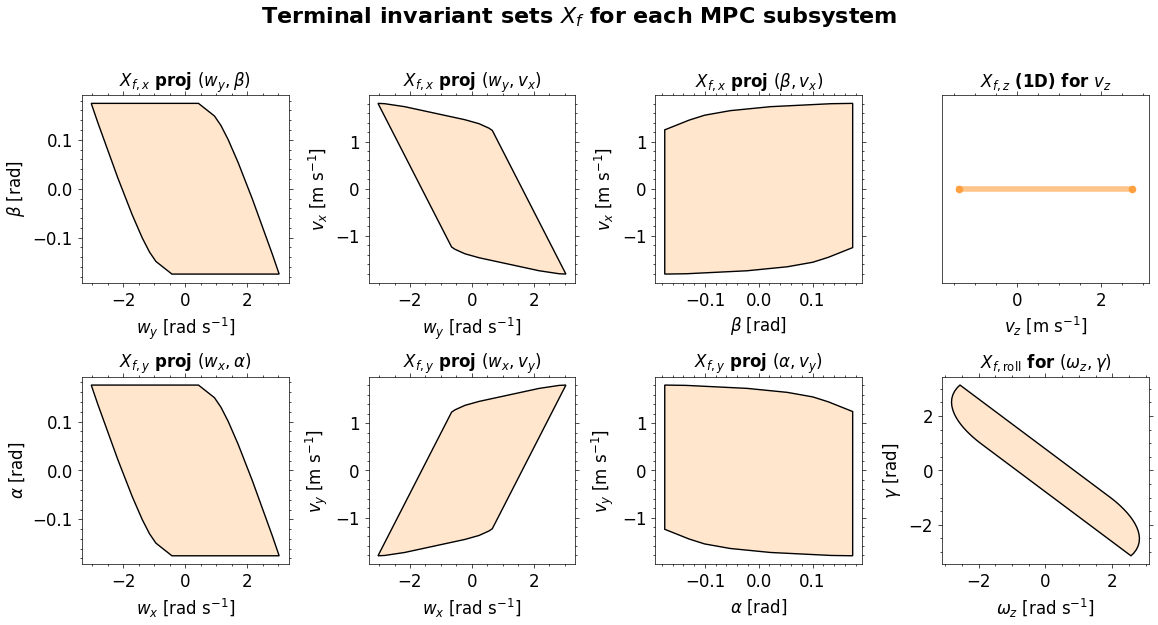

In [13]:
# Plot invariant sets of the final tuned MPCs controllers

xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)

mpc_x = MPCControl_xvel_tuned_final(A, B, xs, us, Ts, H)
mpc_y = MPCControl_yvel_tuned_final(A, B, xs, us, Ts, H)
mpc_z = MPCControl_zvel_tuned_final(A, B, xs, us, Ts, H)
mpc_r = MPCControl_roll_tuned_final(A, B, xs, us, Ts, H)

Xf_x = mpc_x.X_f
Xf_y = mpc_y.X_f
Xf_z = mpc_z.X_f
Xf_r = mpc_r.X_f

# colors from your palette
COL_XF = "#ff9d3a"   # orange for Xf
ALPHA  = 0.25
AXIS_LABEL_SIZE = 12
TICK_LABEL_SIZE = 12
TITLE_SIZE = 12

def plot_poly(ax, P, color=COL_XF, alpha=ALPHA, label=None):
    # mpt4py uses "opacity" rather than alpha
    P.plot(ax, color=color, opacity=alpha, show_vertices=False, label=label)

def plot_1d_interval(ax, P1d, label=None, color=COL_XF):
    """
    Robust 1D plotting: compute bounds from H-rep (A x <= b) assuming bounded interval.
    """
    A = P1d.A
    b = P1d.b

    # inequalities: a_i x <= b_i
    # For 1D, each row is scalar.
    # Upper bounds come from a>0: x <= b/a
    # Lower bounds come from a<0: x >= b/a (since a<0 flips)
    upper = []
    lower = []
    for ai, bi in zip(A.reshape(-1), b.reshape(-1)):
        if ai > 1e-12:
            upper.append(bi / ai)
        elif ai < -1e-12:
            lower.append(bi / ai)  # note ai negative -> bound is lower
    xmin = max(lower) if lower else -np.inf
    xmax = min(upper) if upper else  np.inf

    ax.plot([xmin, xmax], [0, 0], color=color, linewidth=4, alpha=0.6, label=label)
    ax.scatter([xmin, xmax], [0, 0], color=color, s=20, alpha=0.9)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.set_xlim(xmin - 0.1*abs(xmax-xmin), xmax + 0.1*abs(xmax-xmin))

# ---- figure layout: A4 landscape-ish
fig, axs = plt.subplots(2, 4, figsize=(11.69, 6.8))  # A4 wide

fig.suptitle("Terminal invariant sets $X_f$ for each MPC subsystem",
             fontsize=16, fontweight="bold", y=0.98)

# ===== X subsystem (3D) projections
axs[0,0].set_title(r"$X_{f,x}$ proj $(w_y,\beta)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,0], Xf_x.projection(dims=(0,1)))
axs[0,0].set_xlabel(r"$w_y$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[0,0].set_ylabel(r"$\beta$ [rad]", fontsize=AXIS_LABEL_SIZE)

axs[0,1].set_title(r"$X_{f,x}$ proj $(w_y,v_x)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,1], Xf_x.projection(dims=(0,2)))
axs[0,1].set_xlabel(r"$w_y$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[0,1].set_ylabel(r"$v_x$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

axs[0,2].set_title(r"$X_{f,x}$ proj $(\beta,v_x)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,2], Xf_x.projection(dims=(1,2)))
axs[0,2].set_xlabel(r"$\beta$ [rad]", fontsize=AXIS_LABEL_SIZE)
axs[0,2].set_ylabel(r"$v_x$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

# ===== Y subsystem (3D) projections
axs[1,0].set_title(r"$X_{f,y}$ proj $(w_x,\alpha)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,0], Xf_y.projection(dims=(0,1)))
axs[1,0].set_xlabel(r"$w_x$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[1,0].set_ylabel(r"$\alpha$ [rad]", fontsize=AXIS_LABEL_SIZE)

axs[1,1].set_title(r"$X_{f,y}$ proj $(w_x,v_y)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,1], Xf_y.projection(dims=(0,2)))
axs[1,1].set_xlabel(r"$w_x$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[1,1].set_ylabel(r"$v_y$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

axs[1,2].set_title(r"$X_{f,y}$ proj $(\alpha,v_y)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,2], Xf_y.projection(dims=(1,2)))
axs[1,2].set_xlabel(r"$\alpha$ [rad]", fontsize=AXIS_LABEL_SIZE)
axs[1,2].set_ylabel(r"$v_y$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

# ===== Z subsystem (1D) interval
axs[0,3].set_title(r"$X_{f,z}$ (1D) for $v_z$", fontweight="bold", fontsize=TITLE_SIZE)
plot_1d_interval(axs[0,3], Xf_z, label=r"$X_{f,z}$")
axs[0,3].set_xlabel(r"$v_z$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

# ===== Roll subsystem (2D)
axs[1,3].set_title(r"$X_{f,\mathrm{roll}}$ for $(\omega_z,\gamma)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,3], Xf_r, label=r"$X_{f,\mathrm{roll}}$")
axs[1,3].set_xlabel(r"$\omega_z$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[1,3].set_ylabel(r"$\gamma$ [rad]", fontsize=AXIS_LABEL_SIZE)

# cosmetics
for ax in axs.ravel():
    ax.tick_params(labelsize=TICK_LABEL_SIZE)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
fig.savefig("terminal_sets_a4wide.pdf", bbox_inches="tight")
plt.show()



In [14]:
# Calculate trajectory for overlaid later on invariant sets of the final tuned MPCs controllers

import numpy as np
import matplotlib.pyplot as plt
from MPCVelControl_D3_1 import MPCVelControl

# --- build your final tuned full MPC ---
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# initial condition: vx=vy=vz=5 m/s
x0 = xs.copy()
x0[6] += 5.0
x0[7] += 5.0
x0[8] += 5.0
x0[5] += np.deg2rad(30.0)

K_steps = int(sim_time / Ts)

x_cl = np.zeros((12, K_steps+1))
u_cl = np.zeros((4,  K_steps))

# store open-loop predictions at each step
# x_ol_hist[k] has shape (12, N+1)
x_ol_hist = []
t_ol_hist = []

x_cl[:, 0] = x0
t = 0.0
for k in range(K_steps):
    u0, x_ol, u_ol, t_ol = mpc.get_u(t, x_cl[:, k])  # x_ol is 12 x (N+1) (absolute)
    u_cl[:, k] = u0
    x_ol_hist.append(x_ol)
    t_ol_hist.append(t_ol)

    # advance closed-loop (linear model for consistency with your MPC design)
    x_cl[:, k+1] = rocket.simulate_step(x_cl[:, k], Ts, u0, method="linear")
    t += Ts

t_cl = np.arange(K_steps+1) * Ts


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7


Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Maximum invariant set found after 18 iterations !



/Users/mt/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 1

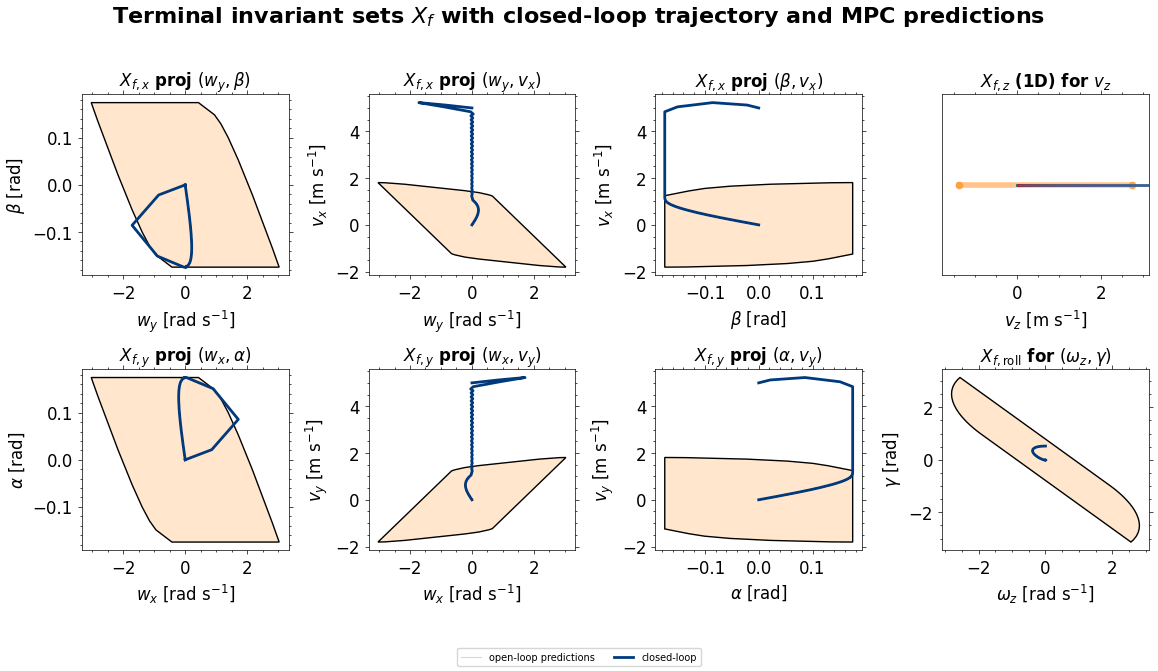

In [15]:
# Plot invariant sets of the final tuned MPCs controllers + trajectory overlaid

# get the final-tuned terminal sets
mpc_x = MPCControl_xvel_tuned_final(A, B, xs, us, Ts, H)
mpc_y = MPCControl_yvel_tuned_final(A, B, xs, us, Ts, H)
mpc_z = MPCControl_zvel_tuned_final(A, B, xs, us, Ts, H)
mpc_r = MPCControl_roll_tuned_final(A, B, xs, us, Ts, H)

Xf_x, Xf_y, Xf_z, Xf_r = mpc_x.X_f, mpc_y.X_f, mpc_z.X_f, mpc_r.X_f

COL_XF = "#ff9d3a"
ALPHA  = 0.25
AXIS_LABEL_SIZE = 12
TICK_LABEL_SIZE = 12
TITLE_SIZE = 12


# --- plotting helpers ---
def plot_poly(ax, P, color=COL_XF, alpha=ALPHA, label=None):
    P.plot(ax, color=color, opacity=alpha, show_vertices=False, label=label)

def plot_1d_interval(ax, P1d, label=None, color=COL_XF):
    A = P1d.A.reshape(-1)
    b = P1d.b.reshape(-1)
    upper, lower = [], []
    for ai, bi in zip(A, b):
        if ai > 1e-12:   upper.append(bi / ai)
        if ai < -1e-12:  lower.append(bi / ai)
    xmin = max(lower) if lower else -np.inf
    xmax = min(upper) if upper else  np.inf

    ax.plot([xmin, xmax], [0, 0], color=color, linewidth=4, alpha=0.6, label=label)
    ax.scatter([xmin, xmax], [0, 0], color=color, s=20, alpha=0.9)
    ax.set_ylim(-1, 1); ax.set_yticks([])
    ax.set_xlim(xmin - 0.1*abs(xmax-xmin), xmax + 0.1*abs(xmax-xmin))

def sub_traj(full_traj, mpc_sub):
    """Convert a full (12, T) ABSOLUTE trajectory to reduced trajectory (nx, T)."""
    return full_traj[mpc_sub.x_ids, :] - mpc_sub.xs[:, None]

def overlay_predictions(ax, mpc_sub, dims,
                        color="#d83034", alpha=0.25, lw=0.8,
                        label="open-loop predictions"):
    """
    Overlay all open-loop MPC predictions on a 2D projection,
    but create only ONE legend entry.
    """
    first = True
    for x_ol in x_ol_hist:
        dx_ol = sub_traj(x_ol, mpc_sub)  # (nx, N+1)
        ax.plot(
            dx_ol[dims[0], :],
            dx_ol[dims[1], :],
            color=color,
            alpha=alpha,
            linewidth=lw,
            label=(label if first else None)
        )
        first = False


def overlay_closedloop(ax, mpc_sub, dims, color="#003a7d", lw=2.0, label="closed-loop"):
    """Overlay closed-loop trajectory on a given 2D projection."""
    dx_cl = sub_traj(x_cl, mpc_sub)         # (nx, K+1)
    ax.plot(dx_cl[dims[0], :], dx_cl[dims[1], :], color=color, linewidth=lw, label=label)

# ---- figure layout ----
fig, axs = plt.subplots(2, 4, figsize=(11.69, 6.8))
fig.suptitle("Terminal invariant sets $X_f$ with closed-loop trajectory and MPC predictions",
             fontsize=16, fontweight="bold", y=0.98)

# ===== X subsystem projections (dims refer to reduced order: [w_y, beta, v_x])
axs[0,0].set_title(r"$X_{f,x}$ proj $(w_y,\beta)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,0], Xf_x.projection(dims=(0,1)))
overlay_predictions(axs[0,0], mpc_x, dims=(0,1),label="open-loop predictions")
overlay_closedloop(axs[0,0], mpc_x, dims=(0,1))

axs[0,1].set_title(r"$X_{f,x}$ proj $(w_y,v_x)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,1], Xf_x.projection(dims=(0,2)))
overlay_predictions(axs[0,1], mpc_x, dims=(0,2),label="open-loop predictions")
overlay_closedloop(axs[0,1], mpc_x, dims=(0,2))

axs[0,2].set_title(r"$X_{f,x}$ proj $(\beta,v_x)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[0,2], Xf_x.projection(dims=(1,2)))
overlay_predictions(axs[0,2], mpc_x, dims=(1,2),label="open-loop predictions")
overlay_closedloop(axs[0,2], mpc_x, dims=(1,2))

# ===== Y subsystem projections (dims refer to reduced order: [w_x, alpha, v_y])
axs[1,0].set_title(r"$X_{f,y}$ proj $(w_x,\alpha)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,0], Xf_y.projection(dims=(0,1)))
overlay_predictions(axs[1,0], mpc_y, dims=(0,1),label="open-loop predictions")
overlay_closedloop(axs[1,0], mpc_y, dims=(0,1))

axs[1,1].set_title(r"$X_{f,y}$ proj $(w_x,v_y)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,1], Xf_y.projection(dims=(0,2)))
overlay_predictions(axs[1,1], mpc_y, dims=(0,2),label="open-loop predictions")
overlay_closedloop(axs[1,1], mpc_y, dims=(0,2))

axs[1,2].set_title(r"$X_{f,y}$ proj $(\alpha,v_y)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,2], Xf_y.projection(dims=(1,2)))
overlay_predictions(axs[1,2], mpc_y, dims=(1,2),label="open-loop predictions")
overlay_closedloop(axs[1,2], mpc_y, dims=(1,2))

# ===== Z subsystem (1D): v_z interval + show closed-loop/predictions along the line
axs[0,3].set_title(r"$X_{f,z}$ (1D) for $v_z$", fontweight="bold", fontsize=TITLE_SIZE)
plot_1d_interval(axs[0,3], Xf_z, label=r"$X_{f,z}$")

# closed-loop v_z points on the line
dxz_cl = (x_cl[mpc_z.x_ids, :] - mpc_z.xs[:, None]).reshape(-1)
axs[0,3].plot(dxz_cl, np.zeros_like(dxz_cl), color="tab:blue", linewidth=2.0)

# open-loop predictions at each step
for x_ol in x_ol_hist:
    dxz_ol = (x_ol[mpc_z.x_ids, :] - mpc_z.xs[:, None]).reshape(-1)
    axs[0,3].plot(dxz_ol, np.zeros_like(dxz_ol), color="tab:red", alpha=0.25, linewidth=0.8)

# ===== Roll subsystem (2D): reduced order [w_z, gamma]
axs[1,3].set_title(r"$X_{f,\mathrm{roll}}$ for $(\omega_z,\gamma)$", fontweight="bold", fontsize=TITLE_SIZE)
plot_poly(axs[1,3], Xf_r, label=r"$X_{f,\mathrm{roll}}$")
overlay_predictions(axs[1,3], mpc_r, dims=(0,1),label="open-loop predictions")
overlay_closedloop(axs[1,3], mpc_r, dims=(0,1))

# labels (keep yours)
axs[0,0].set_xlabel(r"$w_y$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE); axs[0,0].set_ylabel(r"$\beta$ [rad]", fontsize=AXIS_LABEL_SIZE)
axs[0,1].set_xlabel(r"$w_y$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE); axs[0,1].set_ylabel(r"$v_x$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[0,2].set_xlabel(r"$\beta$ [rad]", fontsize=AXIS_LABEL_SIZE);       axs[0,2].set_ylabel(r"$v_x$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

axs[1,0].set_xlabel(r"$w_x$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE); axs[1,0].set_ylabel(r"$\alpha$ [rad]", fontsize=AXIS_LABEL_SIZE)
axs[1,1].set_xlabel(r"$w_x$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE); axs[1,1].set_ylabel(r"$v_y$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)
axs[1,2].set_xlabel(r"$\alpha$ [rad]", fontsize=AXIS_LABEL_SIZE);       axs[1,2].set_ylabel(r"$v_y$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

axs[0,3].set_xlabel(r"$v_z$ [m s$^{-1}$]", fontsize=AXIS_LABEL_SIZE)

axs[1,3].set_xlabel(r"$\omega_z$ [rad s$^{-1}$]", fontsize=AXIS_LABEL_SIZE); axs[1,3].set_ylabel(r"$\gamma$ [rad]", fontsize=AXIS_LABEL_SIZE)

# one legend (closed-loop label comes from first axis)
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=True)

# cosmetics
for ax in axs.ravel():
    ax.tick_params(labelsize=TICK_LABEL_SIZE)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
fig.savefig("terminal_sets_with_cl_and_ol_predictions.pdf", bbox_inches="tight")
plt.show()


In [16]:
# closed-loop trajectory for non-stationnary x0 (combined)

# non-stationnary + 30° roll angle

mpc = MPCVelControl().new_controller(rocket, Ts, H)

omega_x0 = 0; omega_y0 = 0; omega_z0 = 0; alpha0 = 0; beta0 = 0; gamma0 = np.deg2rad(30); v_x0 = 5; v_y0 = 5; v_z0 = 5 # non-stationnary + 30° roll angle
x0 = np.array([omega_x0, omega_y0, omega_z0, alpha0, beta0, gamma0, v_x0, v_y0, v_z0])  # initial states, must not contain the positions !

x0_full = np.zeros(12)
x0_full[:9] = x0

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0_full, method="linear"
)

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Maximum invariant set found after 8 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1


Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Maximum invariant set found after 18 iterations !

Simulating time 0.00: 

/Users/mt/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating time 2.15: 
Simulating

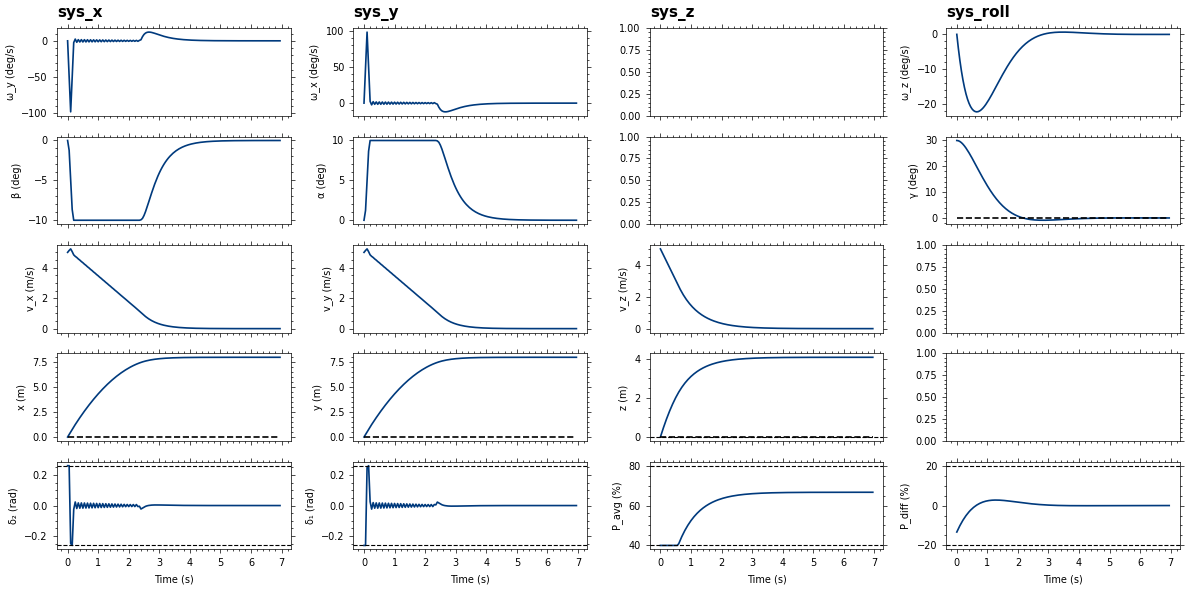

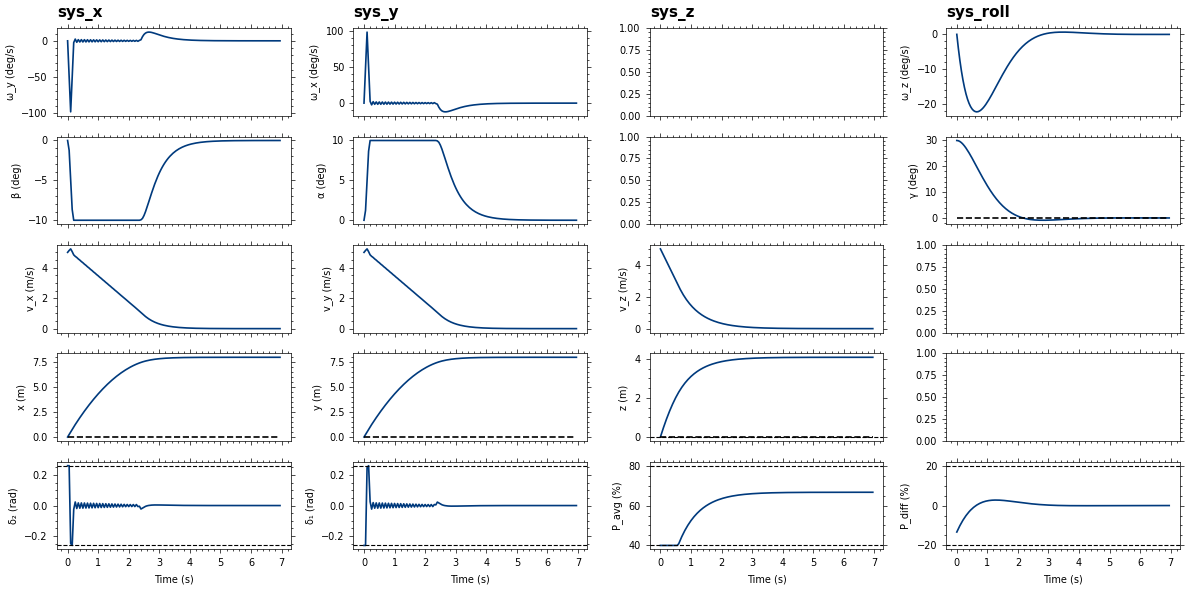

In [17]:
from src.vel_rocket_vis import plot_static_states_inputs
import matplotlib.pyplot as plt

T = t_cl[:-1]
X = x_cl[:, :-1]
U = u_cl
ref = ref[:,:-1]

plot_static_states_inputs(T, X, U, ref)

plt.savefig("closedloop_states_inputs.pdf", bbox_inches="tight")
plt.show()
